# Youtube Scraping

## Package yang digunakan

In [ ]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import numpy

## 1. Membuat Lingkungan Virtual Youtube

In [ ]:
api_key = 'xxxxxxxxxxxxxxx'
channel_ids = ['UC5BMIWZe9isJXLZZWPWvBlg', #KOMPASTV
               'UCKII0Ml9S5wneKbHswmUrIQ', #CNNIndonesia
               'UCER4rvDnRBPr_ncYW4UCZjg', #tvOneNews
               'UCmxAIW7RDDC88EPk4ry16Kg', #Tribunnews
               'UCzl0OrB3-ehunyotIQvK77A', #MetroTV News
               'UCK6c4qk3hRaa6fMIEZrhiXQ', #Tribun Timur
               'UCGN9JsnkvK05v2lnTI_-uGA', #CNBC Indonesia
               'UCuMAjEaSMj7q7YLf0xW1MjQ'  #Detik.com
              ]
youtube = build('youtube','v3',developerKey=api_key)

API key didapatkan dengan cara sebagai berikut:

1. Masuklah ke halaman Google Developer Console di link https://console.developers.google.com/ dan login menggunakan akun Google
2. Klik tombol Buat Project pada halaman dashboard, isi nama project, lalu klik Buat
3. Untuk mendapatkan API Key, klik + AKTIFKAN API DAN LAYANAN atau klik library API pada halaman Project.
4. Kemudian kalian scroll ke bagian Youtube, pilih Youtube Data API v3, lalu klik Aktifkan
5. Untuk mendapat API, diperlukan credential. Klik tombol Buat Kredensial, pilih Kredensial yang dibutuhkan, untuk project ini hanya diputuhkan API Key biasa untuk data publik.
6. Setelah API didapatkan, klik Salin API, selesai.

Channel ID didapatkan dengan cara sebagai berikut:

1. Buka halaman Youtube
2. Pada kolom search, tulis nama channel yang ingin diketahui IDnya.
3. Klik channel dari hasil pencarian, link yang dihasilkan akan menghasilkan ID dari channel tersebut. Sebagai contoh: 
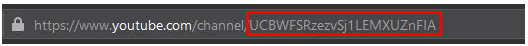
4. Adakalanya, link youtube dari suatu channel sudah dimodifikasi
5. Untuk channel seperti ini, klik pada salah satu video dari channel tersebut, lalu klik logo channel dari halaman video tersebut. Dengan cara itu, channel ID dapat dilihat dari link yang didapatkan.

## 2. Extract Statistik dari Channel

Untuk mendapatkan top 5 channel berita berdasarkan jumlah subscribers nya, kami mengambil 8 channel berita popular lalu mengurutkan berdasarkan jumlah subscribersnya

In [ ]:
## Function to get channel data
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=channel_ids)
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(Channel_ID = response['items'][i]['id'],
                    Channel_Name = response['items'][i]['snippet']['title'],
                    Created_Date = response['items'][i]['snippet']['publishedAt'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Total_Views = response['items'][i]['statistics']['viewCount'],
                    Total_Vid = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return all_data

In [ ]:
channel_data = pd.DataFrame(get_channel_stats(youtube, channel_ids))

In [ ]:
channel_data

### Melakukan penyesuaian tipe data pada tiap kolom

In [ ]:
channel_data.dtypes

In [ ]:
channel_data['Created_Date'] = pd.to_datetime(channel_data['Created_Date']).dt.date
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Total_Views'] = pd.to_numeric(channel_data['Total_Views'])
channel_data['Total_Vid'] = pd.to_numeric(channel_data['Total_Vid'])
channel_data.dtypes

In [ ]:
channel_data

### Mengurutkan data berdasarkan jumlah subscribers

In [ ]:
channel_data = channel_data.sort_values(by=['Subscribers'], ascending=False)
channel_data

### Menyimpan data channel ke format csv

In [ ]:
channel_data.to_csv('Top 8 News Channel.csv', index = False)

In [ ]:
channel_data = pd.read_csv('Top 8 News Channel.csv')
channel_data

### Eksplorasi pada data Channel

In [ ]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(x='Channel_Name', y='Subscribers', data=channel_data)

## 3. Mendapatkan video ids

In [ ]:
playlist_id_kompas = channel_data.loc[channel_data['Channel_Name']=='KOMPASTV','playlist_id'].iloc[0]
playlist_id_cnn = channel_data.loc[channel_data['Channel_Name']=='CNN Indonesia','playlist_id'].iloc[0]
playlist_id_tvone = channel_data.loc[channel_data['Channel_Name']=='tvOneNews ','playlist_id'].iloc[0]
playlist_id_tribun = channel_data.loc[channel_data['Channel_Name']=='Tribunnews','playlist_id'].iloc[0]
playlist_id_timur = channel_data.loc[channel_data['Channel_Name']=='Tribun Timur','playlist_id'].iloc[0]

In [ ]:
playlist_id_cnn

In [ ]:
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
        part = 'contentDetails',
        playlistId = playlist_id,
        maxResults = 50)
    response = request.execute()
    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
    next_page_token = response.get('nextPageToken')
    
    for i in range(400):
        request = youtube.playlistItems().list(
            part = 'contentDetails',
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token)
        response = request.execute()
        for i in range(len(response['items'])):
            video_ids.append(response['items'][i]['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')
    print(next_page_token)

    return video_ids

Fungsi ini digunakan untuk mengambil video ID dari suatu playlist. Video ID didapatkan dari part contentDetails. Dalam fungsi ini, dilakukan looping 500 kali untuk menghindari limit kuota API.

In [ ]:
video_ids_cnn = get_video_ids(youtube, playlist_id_cnn)
video_ids_cnn

In [ ]:
cnn_videos_id = pd.DataFrame(video_ids_cnn)
cnn_videos_id

### Menyimpan video id ke format csv

In [ ]:
cnn_videos_id = cnn_videos_id.to_csv('CNN Videos ID.csv', index = False)
cnn_videos_id

In [ ]:
cnn_videos_id

In [ ]:
cnn_vid_id.values.tolist()

## 4. Mendapatkan Detail Video dari video id

In [ ]:
def get_video_details(youtube, video_ids):
  all_video_stats = []
  for i in range(0, len(video_ids), 50):
    request = youtube.videos().list(
        part = 'snippet, statistics, contentDetails',
        id = ','.join(video_ids[i:i+50]))
    response = request.execute()
    for i in range(len(response['items'])):
      try: 
        Tags = response['items'][i]['snippet']['tags']
      except KeyError:
        Tags = 'Tidak ada tag / tag tidak diizinkan'
      try:
        Likes = response['items'][i]['statistics']['likeCount']
      except KeyError:
        Likes = 'Like Count tidak diizinkan'
      try:
        Views = response['items'][i]['statistics']['viewCount']
      except KeyError:
        Views = 'View Count tidak diizinkan'
      try:
        CommentCount = response['items'][i]['statistics']['commentCount']
      except KeyError:
        CommentCount = 'Comment Count tidak diizinkan'
      video_details = dict(VideoID = response['items'][i]['id'],
                           Title = response['items'][i]['snippet']['title'],
                           PublishedAt = response['items'][i]['snippet']['publishedAt'],
                           Tags = Tags,
                           Duration = response['items'][i]['contentDetails']['duration'],
                           Likes = Likes,
                           Views = Views,
                           CommentCount = CommentCount)
      
      all_video_stats.append(video_details)

  return all_video_stats

fungsi "try" dan "except" digunakan karena ada beberapa video yang tidak mengizinkan untuk mendapatkan variable tertentu

In [ ]:
videos_detail_cnn = get_video_details(youtube, video_ids_cnn)
videos_data_cnn = pd.DataFrame(videos_detail_cnn)

### Melakukan penyesuaian tipe data

In [ ]:
videos_data_cnn['PublishedAt'] = pd.to_datetime(videos_data_cnn['PublishedAt']).dt.date
videos_data_cnn['Views'] = pd.to_numeric(videos_data_cnn['Views'])

In [ ]:
import isodate
videos_data_cnn['Duration'] = videos_data_cnn['Duration'].apply(
    lambda row: isodate.parse_duration(row).total_seconds()
)

In [9]:
videos_data_cnn

,VideoID,Title,PublishedAt,Tags,Duration,Likes,Views,CommentCount
0,U3c-NvIgFrg,Kesejukan Masjid Namira,2022-04-22,Tidak ada tag / tag tidak diizinkan,223.0,96,2025,15
1,HhwShDlAN6w,Keterbatasan Tidak Jadi Penghalang untuk Berkarya,2022-04-22,Tidak ada tag / tag tidak diizinkan,414.0,6,531,0
2,3bT0eTWmvHA,"Diperiksa 2 Jam, Rossa Siap Kembalikan Uang da...",2022-04-22,"['rossa', 'dna pro', 'bareskrim polri', 'polri']",104.0,10,1127,4
3,TCfkAfF2w44,Kejagung Ungkap Alasan Dirjen Kemendag Tersang...,2022-04-22,"['Kejagung', 'Kasus Izin CPO', 'Kasus Minyak G...",130.0,40,4434,37
4,dIL76oV02vk,Arus Mudik Mulai Terlihat di Beberapa Lokasi,2022-04-22,"['mudik', 'mudik lebaran', 'mudik lebaran 2022...",110.0,113,4433,23
...,...,...,...,...,...,...,...,...
19835,7IngHpQjgLk,Gajah Indonesia Diambang Kepunahan,2020-08-12,"['Indonesia', 'cnn indonesia', 'berita', 'beri...",272.0,115,10091,43
19836,esY1NN-CekE,Bawaslu Temukan Ribuan Data Pemilih Bermasalah,2020-08-12,"['Indonesia', 'cnn indonesia', 'berita', 'beri...",272.0,30,2939,20
19837,dfP7rDyNGr4,Mengukur Efektivitas Rapid Test Antigen,2020-08-12,"['Indonesia', 'cnn indonesia', 'berita', 'beri...",447.0,190,46835,75
19838,XuJ8vMBZ2qk,Okupansi Hotel di Pulau Dewata Mulai Meningkat,2020-08-12,"['Indonesia', 'cnn indonesia', 'berita', 'beri...",578.0,95,4629,17
